In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import skfuzzy as fuzz

In [ ]:
################################################## HELPER FUNCTIONS #################################################################################### 
def z_scoring(x): 
    return (x - x.mean()) / x.std()

def range_normalization(x):
    return (x - x.mean()) / (x.max() - x.min())

def center_(x, cluster):
    return [np.mean(x[cluster, j]) for j in range(x.shape[1])]

# Used to group dataPoints in clusters
def distNorm(x ,remains, ranges, p):
    z = x[remains, :]
    az = np.tile(p, (len(remains), 1))
    rz = np.tile(ranges, (len(remains), 1))
    dz = (z - az) / rz
    return np.sum(dz * dz, axis=1)

# To See if it belongs to Cluster X?
def separCluster(x, remains, ranges, a, b):
    dista = distNorm(x, remains, ranges, a)
    distb = distNorm(x, remains, ranges, b)
    return [remains[i] for i in np.where(dista < distb)[0]]

def anomalousPattern(x, remains, ranges, centroid, me):
    while True:
        cluster = separCluster(x, remains, ranges, centroid, me)
        if not cluster:
            break
        newcenter = center_(x, cluster)
        if np.allclose(centroid, newcenter):
            break
        centroid = newcenter
    return cluster, centroid

def dist(x, remains, ranges, p):
    return np.sum(((x[remains] - p) / ranges) ** 2, axis=1)

In [19]:
################################################## DATA PREPARATION #################################################################################### 

# a ) Normalize by range and z-score
# MERGED dataSet
df_r = pd.read_csv("./data/winequality-red.csv", sep=';')
df_w = pd.read_csv("./data/winequality-white.csv", sep=';')
data = pd.concat([df_r, df_w], ignore_index=True)

# Z-Score Normalization
data_ap_zscore = z_scoring(data)

# Range Normalization
data_ap_range = range_normalization(data)

# Convert to NumPy array for clustering
x = data_ap_zscore.values.astype(np.float32)

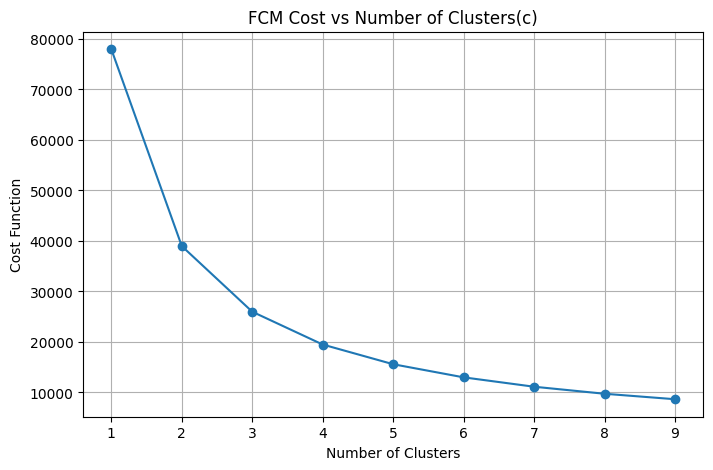

In [ ]:
# b) 
costs = []
c_values = list(range(1, 10))
n_runs = 5
seeds=[1, 42, 70, 100, 200]


for c in c_values:
    run_costs = []
    for _ in range(1, 5):
        #centers = cluster centers (c, features)
        #fm = final matrix (c, samples)
        #im = initial matrix (c, samples)
        #d = distance from each cluster to each sample (c, samples)
        #jm = history of cost functions for each iteration
        centers, fm, im, d, jm, i, fpc = fuzz.cluster.cmeans(x.T, c, 2.0, 1e-5, 1000, init=None, seed=seeds)
        
        # Last value of the history
        run_costs.append(jm[-1])

    avg_cost = np.mean(run_costs)
    costs.append(avg_cost) #append average cost of the 5 runs for Cluster c

# (c_values, avg_cost) 
plt.figure(figsize=(8,5))
plt.plot(c_values, costs, marker='o', linestyle='-')
plt.title("FCM Cost vs Number of Clusters(c)")
plt.xlabel("Number of Clusters")
plt.ylabel("Cost Function")
plt.grid(True)
plt.show()

#By elbow, c = 2 or c = 3. Elbow method is a good starting point, but not necessarely the most reliable way to do this.
#Further analysis is required to find the best number of clusters
